In [15]:
from pykrx import stock 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# 종목 이름에 맞는 ticker 구하기 
for ticker in stock.get_market_ticker_list():
    if stock.get_market_ticker_name(ticker) == '하이브':
        hybe_num = ticker 

for ticker in stock.get_index_ticker_list(market='KOSDAQ'):
    if stock.get_index_ticker_name(ticker) == '코스닥':
        kosdaq_num = ticker

# 데이터 불러오고 필드 이름 영어로 재설정 
kosdaq = stock.get_index_ohlcv('2020-01-01','2025-01-01',kosdaq_num)
hybe = stock.get_market_ohlcv('2020-01-01','2025-01-01',hybe_num)

kosdaq = kosdaq.rename(columns = {'시가': 'Open','고가':'High','저가':'Low', '종가':'Close', '거래량':'Volume'})
hybe = hybe.rename(columns = {'시가' : 'Open', '고가' : 'High', '저가' : 'Low', '종가' : 'Close', '거래량' : 'Volume'})


In [17]:
# MACD 계산 함수 
def cal_macd(data, short, long, speriod): 
    short_ema = data['Close'].ewm(span=short, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long, adjust=False).mean()
    macd = short_ema - long_ema 
    data['MACD'] = macd
    
    signal = macd.ewm(span = speriod,adjust=False).mean()
    data['Signal'] = signal
    return data

In [18]:
kosdaq = cal_macd(kosdaq, 12,26, 9)
hybe = cal_macd(hybe, 12,26, 9)

In [19]:
# 주가(종가) 그래프 그리기 
def draw_close(data, title, legend):
    plt.plot(data['Close'], label='Close Price')
    plt.title(f'{title} - Close Price')
    plt.legend(loc=legend)

In [20]:
# MACD 그래프 그리기
def draw_macd(data, title, legend):

    plt.plot(data['MACD'], label='MACD', color='blue')
    plt.plot(data['Signal'], label='Signal Line', color='red')
    plt.bar(data.index, data['MACD']-data['Signal'], label = 'Histogram', color='gray', \
            alpha = 0.5)
    plt.title(f'{title} - MACD(12,26,9)')
    plt.legend(loc=legend)


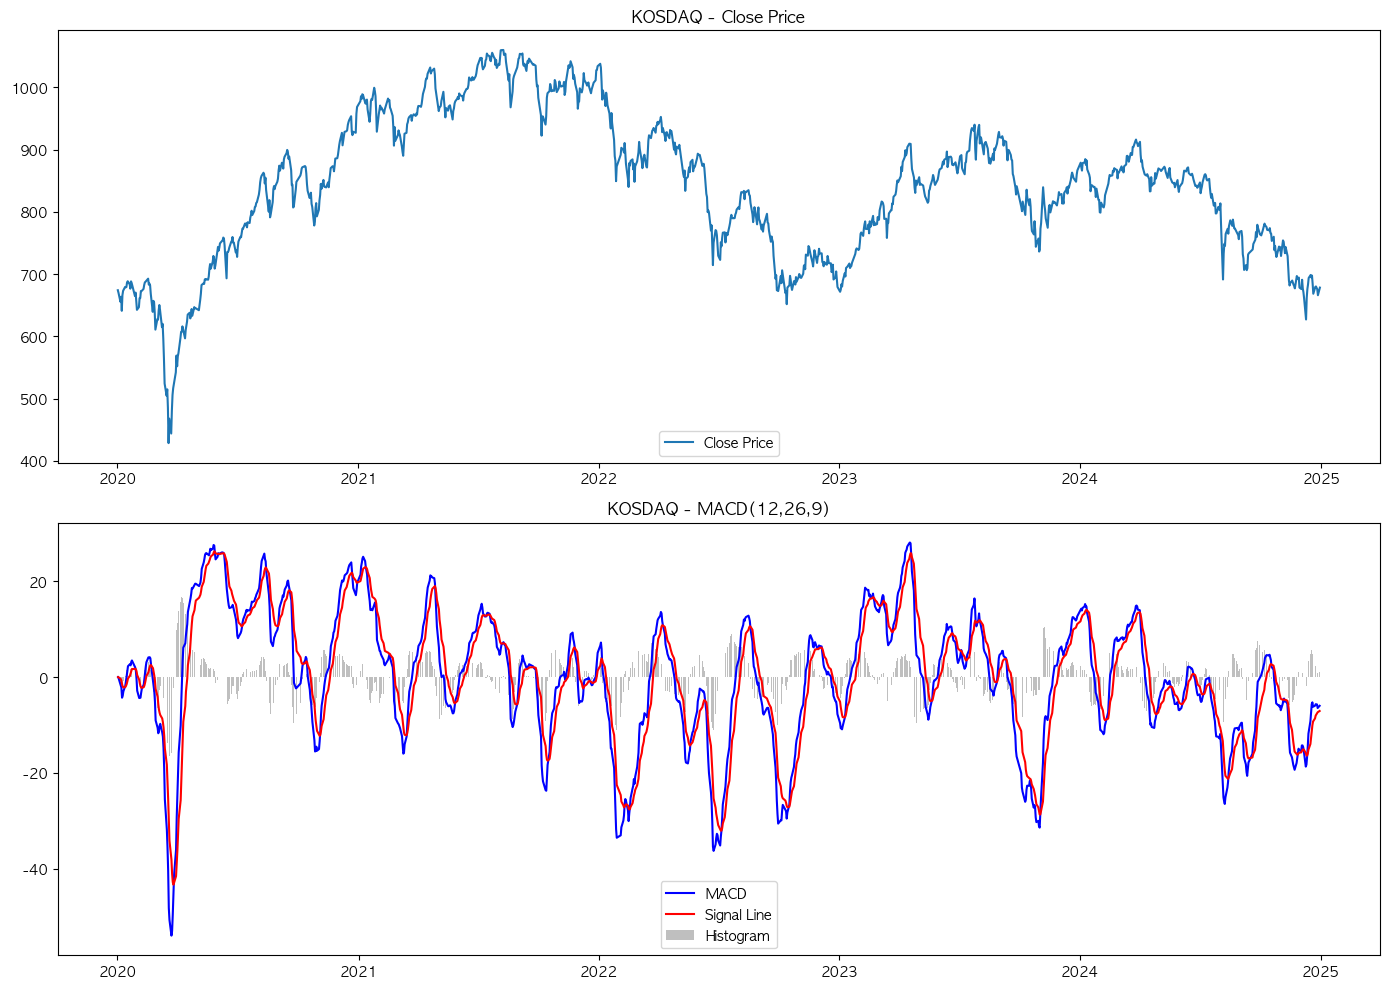

In [21]:
# 코스닥 주가 및 MACD 그래프 
plt.figure(figsize=(14,10))

plt.subplot(2,1,1)
draw_close(kosdaq, 'KOSDAQ', 'lower center')

plt.subplot(2,1,2)
draw_macd(kosdaq, 'KOSDAQ', 'lower center')

plt.tight_layout()
plt.savefig('kosdaq_typ.png')

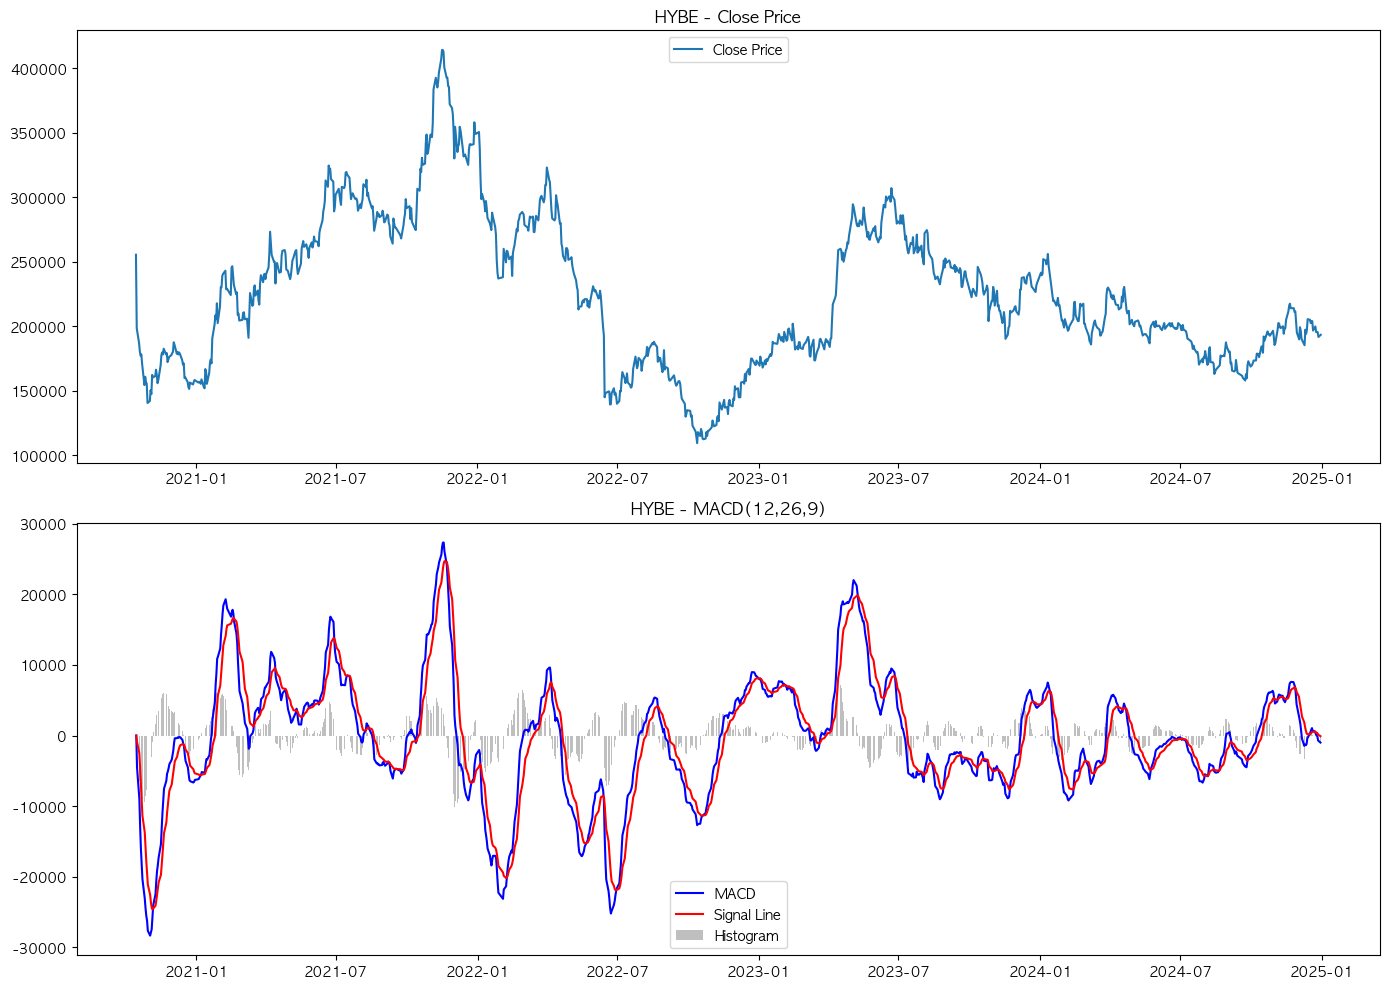

In [22]:
# 하이브 주가 및 MACD 그래프 
plt.figure(figsize=(14,10))

plt.subplot(2,1,1)
draw_close(hybe, 'HYBE', 'upper center')

plt.subplot(2,1,2)
draw_macd(hybe, 'HYBE', 'lower center')

plt.tight_layout()
plt.savefig('hybe_typ.png')

In [23]:
# Stochastic K, D 계산 
def cal_sto(data, k, d):
    low_min = data['Low'].rolling(window=k).min()
    high_max = data['High'].rolling(window=k).max()

    data['%K'] = 100 * ((data['Close'] - low_min) / (high_max - low_min))
    data['%D'] = data['%K'].rolling(window=d).mean()
    return data 


In [24]:
kosdaq = cal_sto(kosdaq, 14,3)
hybe = cal_sto(hybe, 14,3)

In [25]:
# Stochastic Oscillator 그리기 
def draw_sto(data, title, legend):

    plt.plot(data['%K'], label='%K', color='green')
    plt.plot(data['%D'], label='%D', color='orange')
    plt.axhline(y=80, color='red', linestyle='--', label='Overbought (80)')
    plt.axhline(y=20, color='blue', linestyle='--', label='Oversold (20)')
    plt.title(f'{title} - Stochastic Oscillator (%K=14, %D=3)')
    plt.legend(loc=legend, bbox_to_anchor=(0.5,-0.25))
    


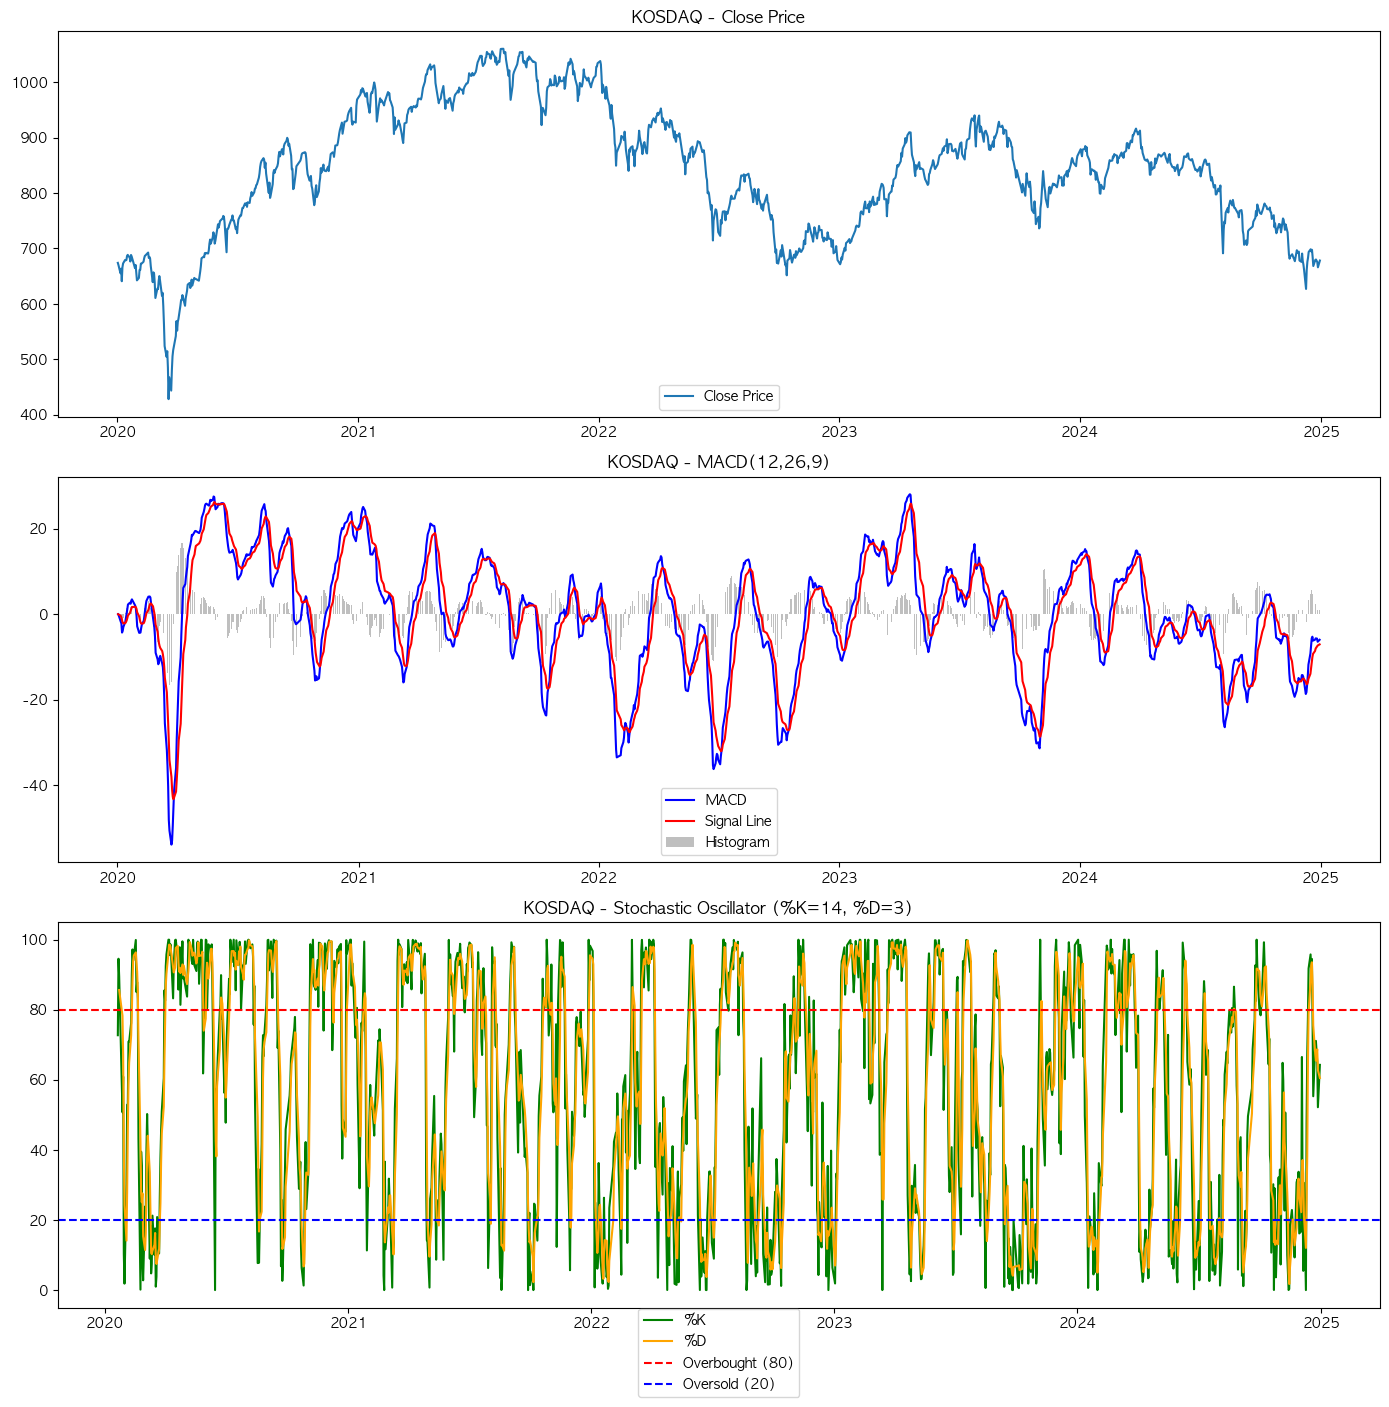

In [26]:
# 코스닥 MACD 및 Stochastic Oscillator 
plt.figure(figsize=(14,14))

plt.subplot(3,1,1)
draw_close(kosdaq, 'KOSDAQ', 'lower center')

plt.subplot(3,1,2)
draw_macd(kosdaq, 'KOSDAQ', 'lower center')

plt.subplot(3,1,3)
draw_sto(kosdaq, 'KOSDAQ', 'lower center')

plt.tight_layout()
plt.savefig('kosdaq_typ_sto.png')

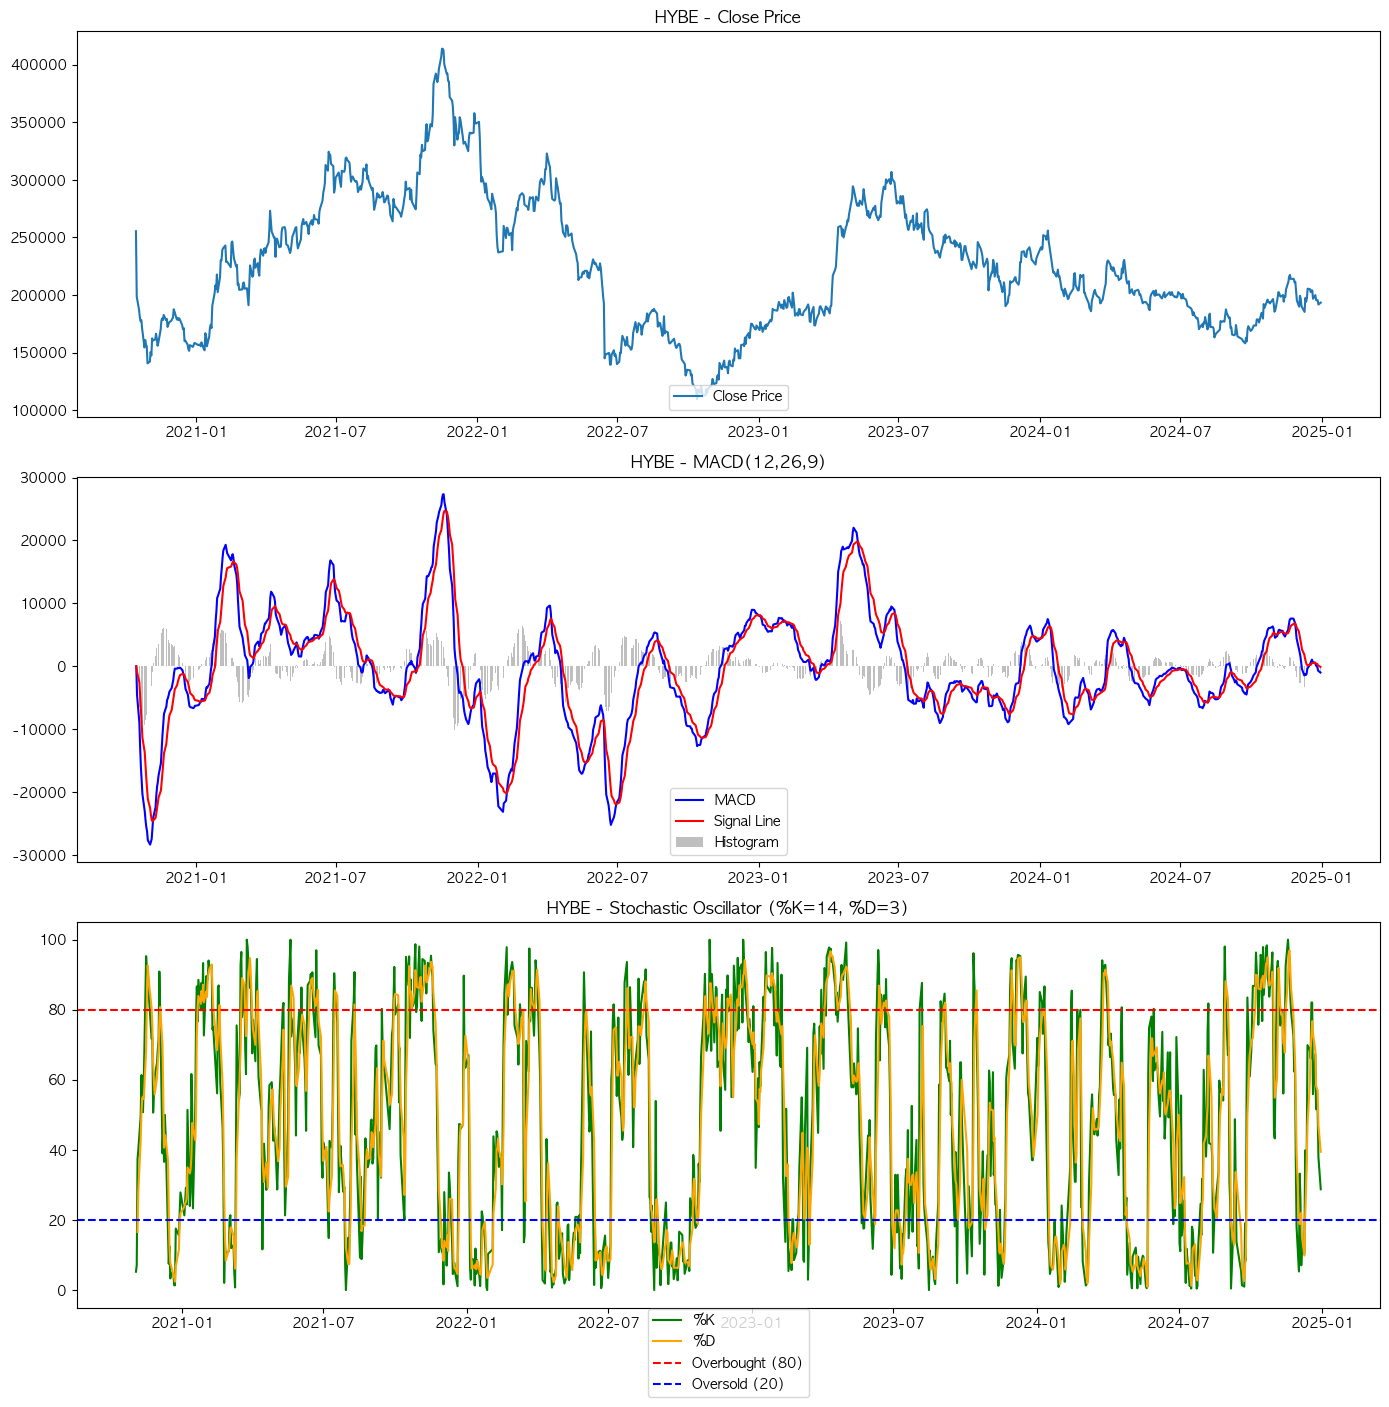

In [27]:
# 하이브 MACD 및 Stochastic Oscillator 
plt.figure(figsize=(14,14))

plt.subplot(3,1,1)
draw_close(hybe, 'HYBE', 'lower center')

plt.subplot(3,1,2)
draw_macd(hybe, 'HYBE', 'lower center')

plt.subplot(3,1,3)
draw_sto(hybe, 'HYBE', 'lower center')

plt.tight_layout()
plt.savefig('hybe_typ_sto.png')
plt.show()

In [28]:
# 누적 수익률 계산 함수 (MACD 고려)
def cal_cumreturn(data):
    data['Position'] = np.where(data['MACD'] > data['Signal'], 1, -1)  # 매수(1), 매도(-1)
    data['Market_Return'] = data['Close'].pct_change()
    data['Strategy_Return'] = data['Market_Return'] * data['Position'].shift(1)
    data['Cumulative_Return'] = (1 + data['Strategy_Return']).cumprod()
    return data

In [29]:
kosdaq = cal_cumreturn(kosdaq)
hybe = cal_cumreturn(hybe)

In [30]:
# 누적 수익률 계산 함수(MACD, 스토캐스틱 동시 고려)
def cal_cumreturn_sto(data):
    data['Position_sto'] = np.where((data['MACD'] > data['Signal']) & (data['%K'] > data['%D']),1, -1)  # 매수(1), 매도(-1)
    data['Market_Return_sto'] = data['Close'].pct_change()
    data['Strategy_Return_sto'] = data['Market_Return_sto'] * data['Position_sto'].shift(1)
    data['Cumulative_Return_sto'] = (1 + data['Strategy_Return_sto']).cumprod()
    return data

In [31]:
kosdaq = cal_cumreturn_sto(kosdaq)
hybe = cal_cumreturn_sto(hybe)

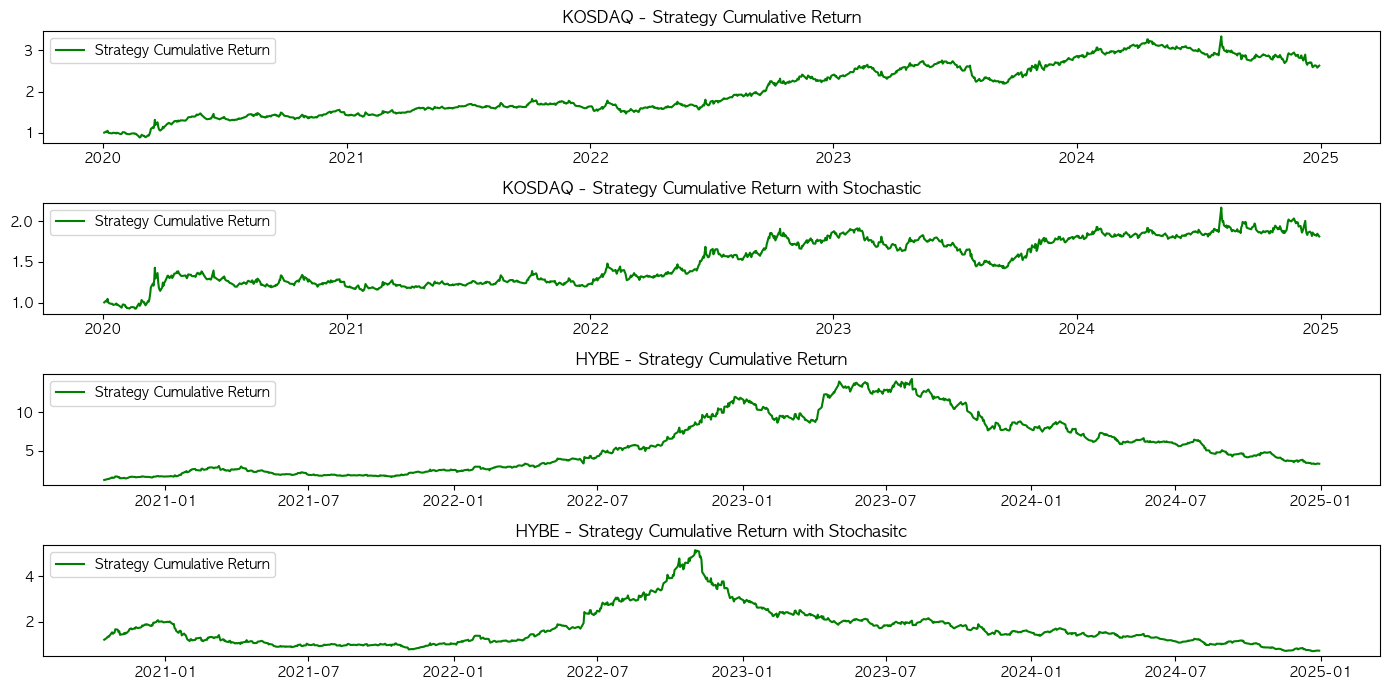

In [32]:
# 누적 수익률 그래프 
plt.figure(figsize=(14,7))    

plt.subplot(4,1,1)
plt.plot(kosdaq['Cumulative_Return'], label='Strategy Cumulative Return', color='green')
plt.title('KOSDAQ - Strategy Cumulative Return')
plt.legend(loc='upper left')

plt.subplot(4,1,2)
plt.plot(kosdaq['Cumulative_Return_sto'], label='Strategy Cumulative Return', color='green')
plt.title('KOSDAQ - Strategy Cumulative Return with Stochastic')
plt.legend(loc='upper left')

plt.subplot(4,1,3)
plt.plot(hybe['Cumulative_Return'], label='Strategy Cumulative Return', color='green')
plt.title('HYBE - Strategy Cumulative Return')
plt.legend(loc='upper left')

plt.subplot(4,1,4)
plt.plot(hybe['Cumulative_Return_sto'], label='Strategy Cumulative Return', color='green')
plt.title('HYBE - Strategy Cumulative Return with Stochasitc')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('Cumreturn_basic.png')

In [33]:
# 최적 MACD 기간 파라미터 구하는 함수 
def grid_search_macd(data, short_range, long_range, signal_range):
    best_return = -np.inf
    best_params = (0, 0, 0)
    best_data = data.copy()

    # 모든 조합 탐색
    for short_period in short_range:
        for long_period in long_range:
            for signal_period in signal_range:
                if short_period >= long_period:
                    continue  # 단기 EMA는 장기 EMA보다 짧아야 함
                result = cal_macd(data.copy(), short_period, long_period, signal_period)
                result = cal_cumreturn(result)
                if result.Cumulative_Return.iloc[-1] > best_return: # 최고 수익률 갱신 
                    best_return = result.Cumulative_Return.iloc[-1]
                    best_params = (short_period, long_period, signal_period)
                    best_data = result 

    return best_params, best_return, best_data 

In [34]:
short_range = range(8, 16) # 단기 EMA 범위 
long_range = range(20, 31) # 장기 EMA 범위    
signal_range = range(5, 11) # 시그널 EMA 범위 

# 코스닥 데이터에 Grid search 적용 
best_kosdaq_params, best_kosdaq_return, best_kosdaq_data = grid_search_macd(kosdaq, short_range, long_range, signal_range)
# print(f"코스닥 최적 param: {best_kosdaq_params}, 누적 수익률: {best_kosdaq_return:.2f}")
# 하이브 데이터에 Grid Search 적용
best_hybe_params, best_hybe_return, best_hybe_data = grid_search_macd(hybe, short_range, long_range, signal_range)
# print(f"하이브 최적 param: {best_hybe_params}, 누적 수익률: {best_hybe_return_return:.2f}")

In [35]:
# 파라미터에 맞게 MACD 그래프 이름 바꾸기 
def draw_opt_macd(data, title, best_data_params, legend):
    
    plt.plot(data['MACD'], label='MACD', color='blue')
    plt.plot(data['Signal'], label='Signal Line', color='red')
    plt.bar(data.index, data['MACD']-data['Signal'], label = 'Histogram', color='gray', \
            alpha = 0.5)
    plt.title(f'{title} - MACD({best_data_params[0]}, {best_data_params[1]}, {best_data_params[2]})')
    plt.legend(loc=legend)

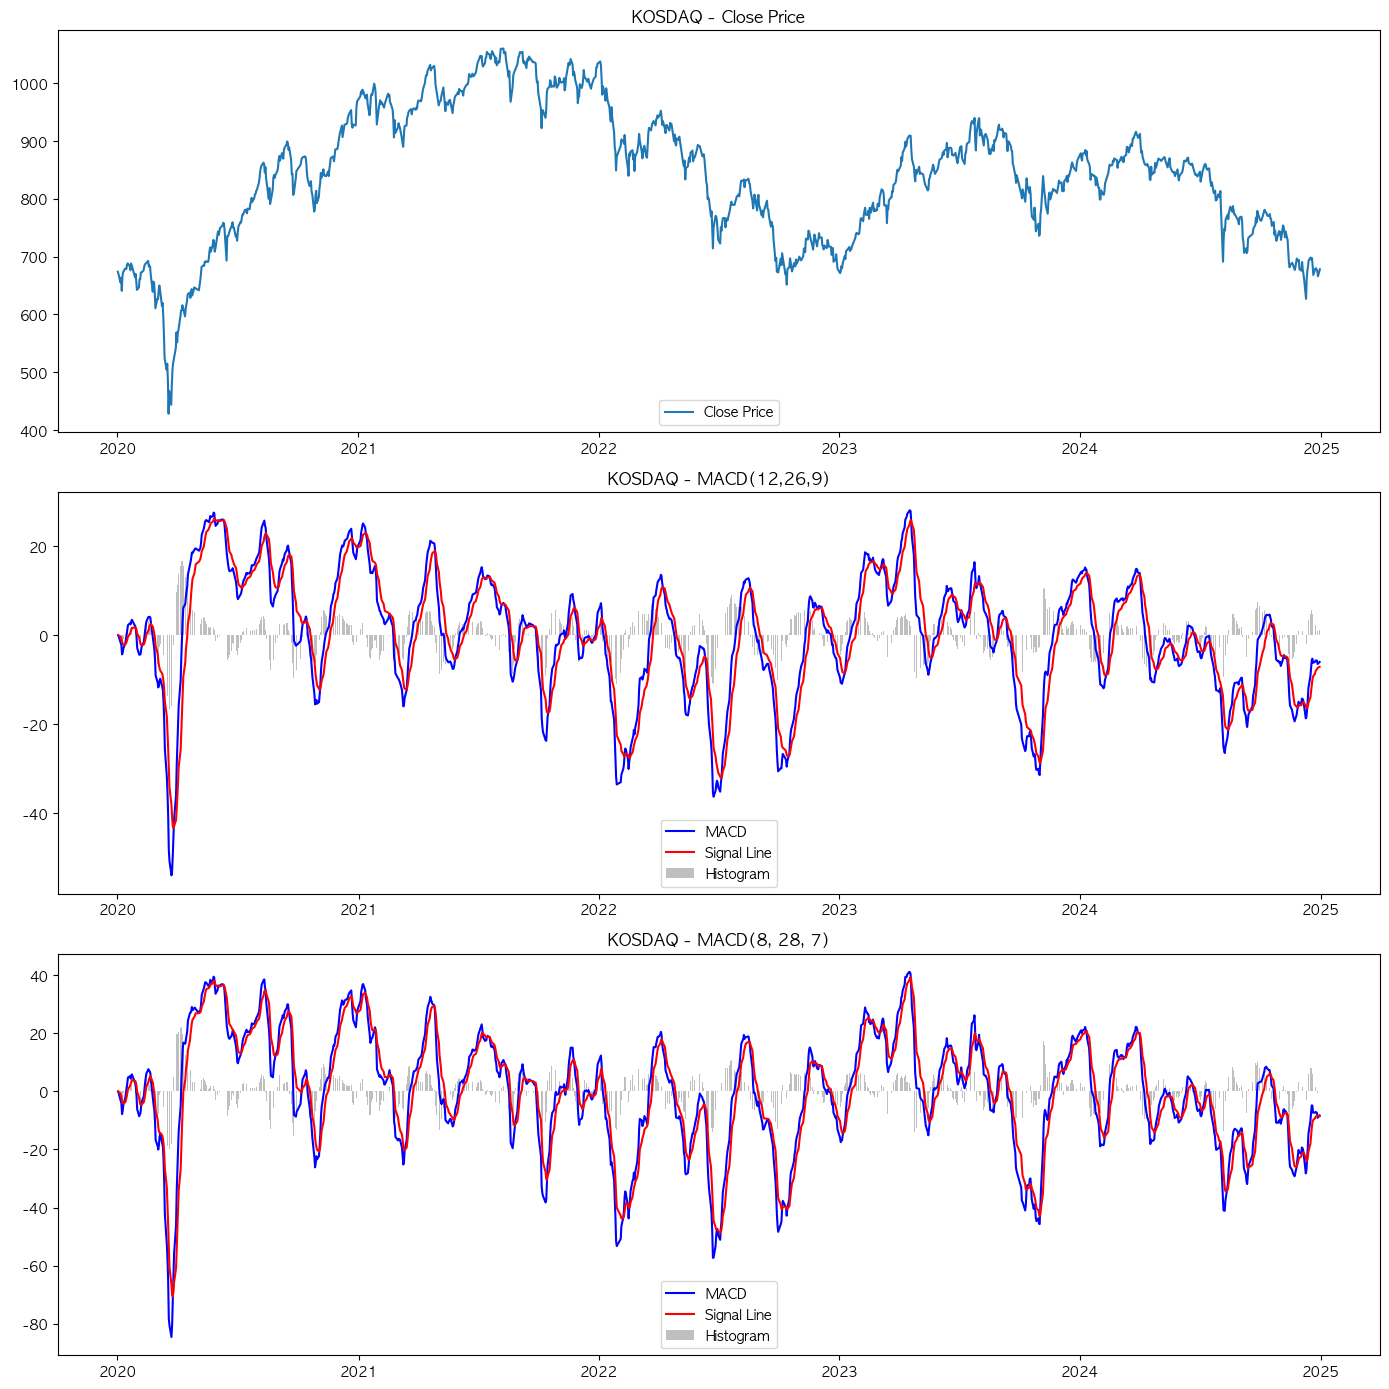

In [36]:
# 최적 파라미터로 MACD 시각화
plt.figure(figsize=(14,14))

plt.subplot(3,1,1)
draw_close(kosdaq, 'KOSDAQ', 'lower center')
plt.subplot(3,1,2)
draw_macd(kosdaq, 'KOSDAQ', 'lower center') # MACD(12,26,9)

plt.subplot(3,1,3)
draw_opt_macd(best_kosdaq_data, 'KOSDAQ', best_kosdaq_params, 'lower center')

plt.tight_layout()
plt.savefig('kosdaq_optMACD.png')

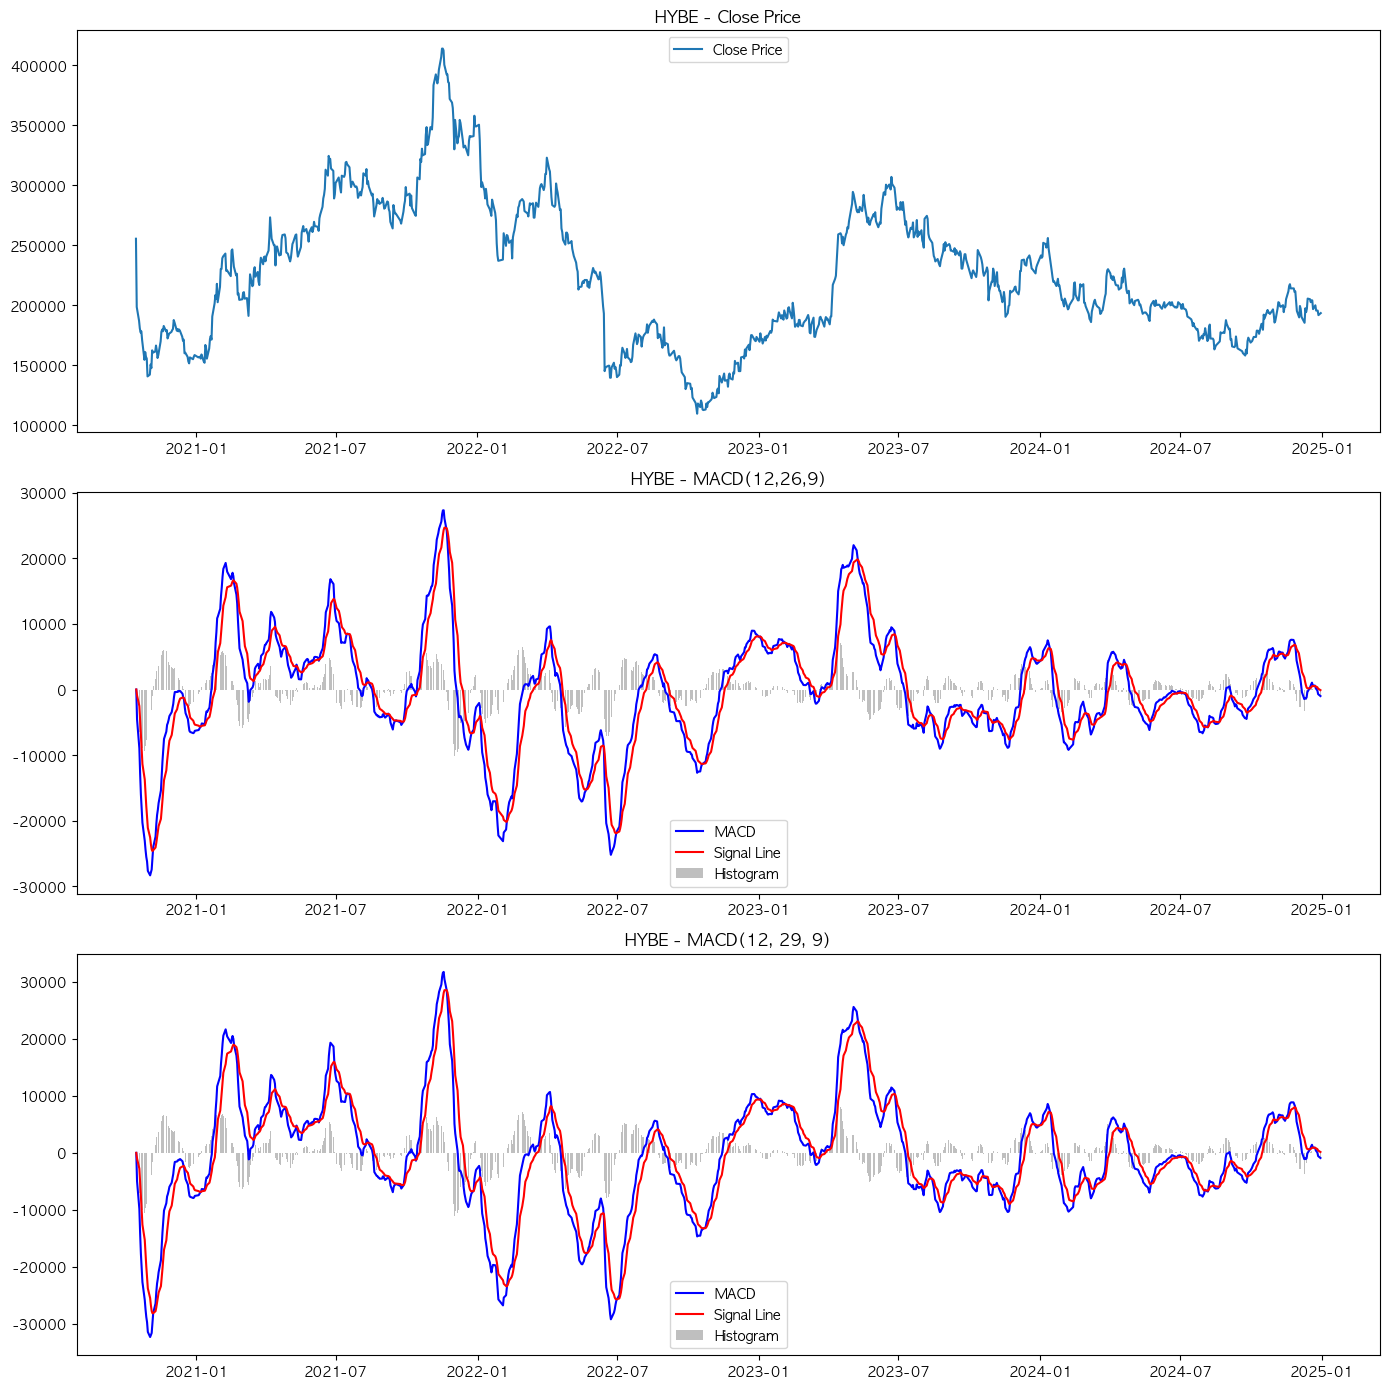

In [37]:
plt.figure(figsize=(14,14))

plt.subplot(3,1,1)
draw_close(hybe, 'HYBE', 'upper center')
plt.subplot(3,1,2)
draw_macd(hybe, 'HYBE', 'lower center') # MACD(12,26,9)
plt.subplot(3,1,3)
draw_opt_macd(best_hybe_data, 'HYBE', best_hybe_params, 'lower center')

plt.tight_layout()
plt.savefig('hybe_optMACD.png')

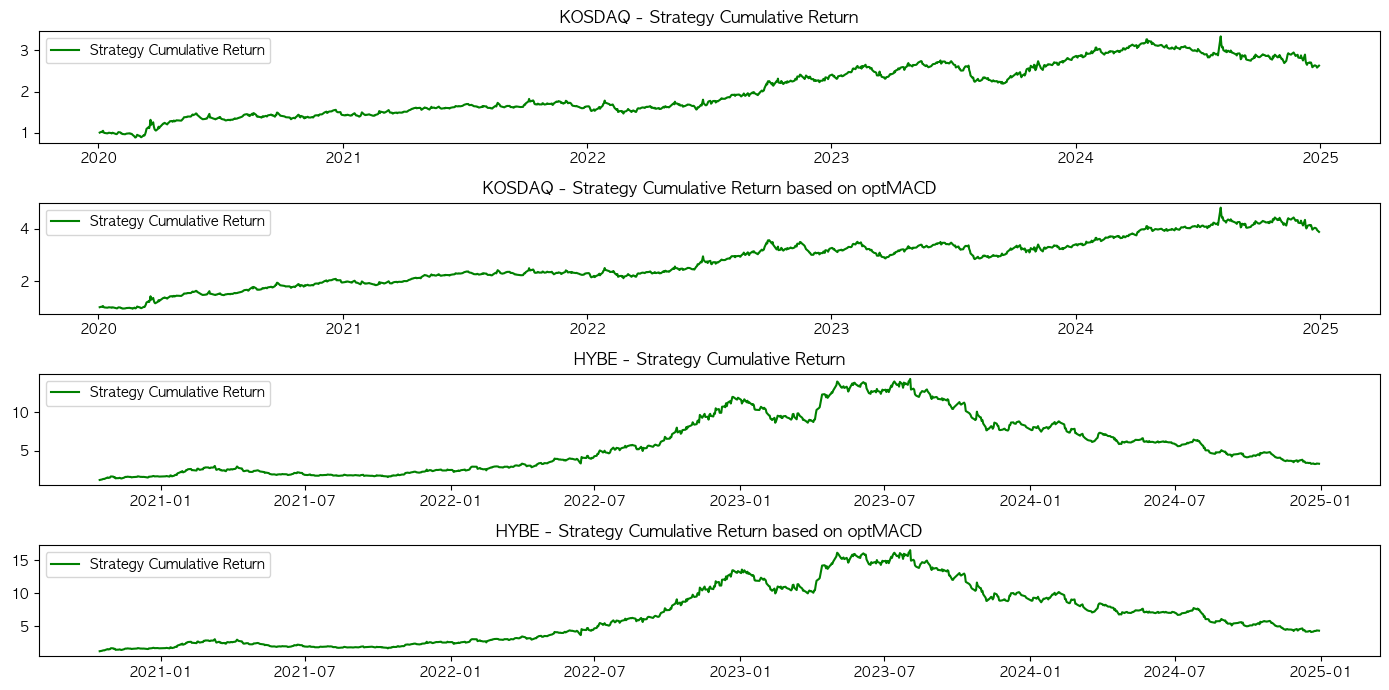

In [38]:
# 기존 누적 수익률과 최적 MACD 기반 누적 수익률 비교 차트 
plt.figure(figsize=(14,7))    

plt.subplot(4,1,1)
plt.plot(kosdaq['Cumulative_Return'], label='Strategy Cumulative Return', color='green')
plt.title('KOSDAQ - Strategy Cumulative Return')
plt.legend(loc='upper left')

plt.subplot(4,1,2)
plt.plot(best_kosdaq_data['Cumulative_Return'], label='Strategy Cumulative Return', color='green')
plt.title('KOSDAQ - Strategy Cumulative Return based on optMACD')
plt.legend(loc='upper left')

plt.subplot(4,1,3)
plt.plot(hybe['Cumulative_Return'], label='Strategy Cumulative Return', color='green')
plt.title('HYBE - Strategy Cumulative Return')
plt.legend(loc='upper left')

plt.subplot(4,1,4)
plt.plot(best_hybe_data['Cumulative_Return'], label='Strategy Cumulative Return', color='green')
plt.title('HYBE - Strategy Cumulative Return based on optMACD')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('Cumreturn_optMACD.png')

In [39]:
# alpha값 변경하여 macd 계산 함수 
def cal_macd_alpha(data, salpha, lalpha, sigalpha):
    short_ema = data['Close'].ewm(alpha=salpha, adjust=False).mean()
    long_ema = data['Close'].ewm(alpha=lalpha, adjust=False).mean()
    macd = short_ema - long_ema 
    data['MACD'] = macd
    
    signal = macd.ewm(alpha = sigalpha,adjust=False).mean()
    data['Signal'] = signal
    return data

In [40]:
# 최적 alpha 값 찾기 
def grid_search_alpha(data, alpha_range):
    best_return = -np.inf
    best_params = (0, 0, 0)
    best_data = data.copy()

    # 모든 조합 탐색
    for salpha in alpha_range:
        for lalpha in alpha_range:
            for sigalpha in alpha_range:
                if salpha <= lalpha:
                    continue  # 단기의 alpha는 장기의 alpha보다 클 것임.(alpha = s/(1+d))
                result = cal_macd_alpha(data.copy(), salpha, lalpha, sigalpha)
                result = cal_cumreturn(result)
                if result.Cumulative_Return.iloc[-1] > best_return: # 최고값 갱신 
                    best_return = result.Cumulative_Return.iloc[-1]
                    best_params = (salpha, lalpha, sigalpha)
                    best_data = result 

    return best_params, best_return, best_data 

In [41]:
alpha_range = np.arange(0.01,0.51,0.05) # alpha 범위 설정 

best_kosdaq_alphas, best_kosdaq_return_alpha, best_kosdaq_data_alpha = grid_search_alpha(kosdaq, alpha_range)
# print(f"코스닥 최적 alpha: {best_kosdaq_alphas}, 누적 수익률: {best_kosdaq_return_alpha:.2f}")

# 하이브 데이터에 Grid Search 적용
best_hybe_alphas, best_hybe_return_alpha, best_hybe_data_alpha = grid_search_alpha(hybe, alpha_range)
# print(f"하이브 최적 alpha: {best_hybe_alphas}, 누적 수익률: {best_hybe_return_alpha:.2f}")

In [42]:
# alpha를 일(day)로 환산 
def alpha_to_day(alpha):
    day = [] 
    for a in alpha:
        day.append(round((2/a)-1))
    return day

best_kosdaq_day = alpha_to_day(best_kosdaq_alphas)
best_hybe_day = alpha_to_day(best_hybe_alphas)

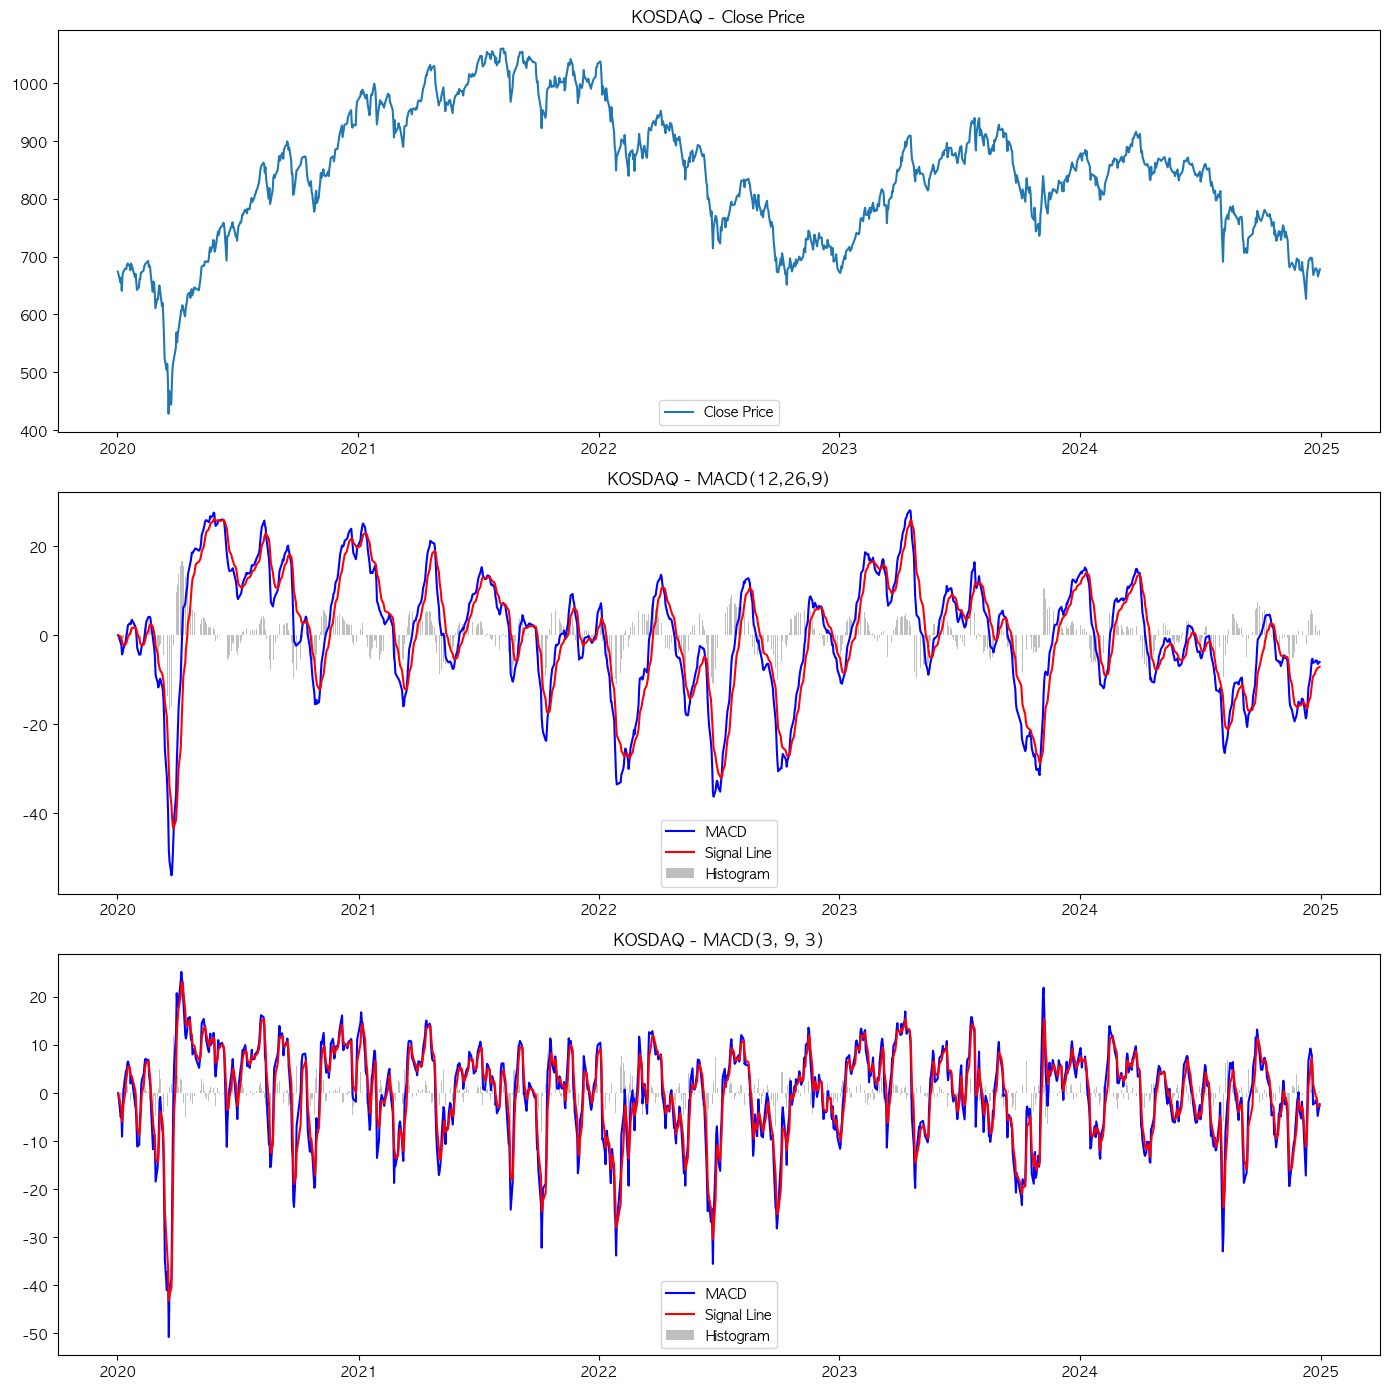

In [43]:
# 코스닥 - 최적 alpha 기반의 MACD 그래프 시각화  
plt.figure(figsize=(14,14))

plt.subplot(3,1,1)
draw_close(kosdaq, 'KOSDAQ', 'lower center')
plt.subplot(3,1,2)
draw_macd(kosdaq, 'KOSDAQ', 'lower center') # MACD(12,26,9)

plt.subplot(3,1,3)
draw_opt_macd(best_kosdaq_data_alpha, 'KOSDAQ', best_kosdaq_day, 'lower center')

plt.tight_layout()
plt.savefig('kosdaq_optalpha.png')

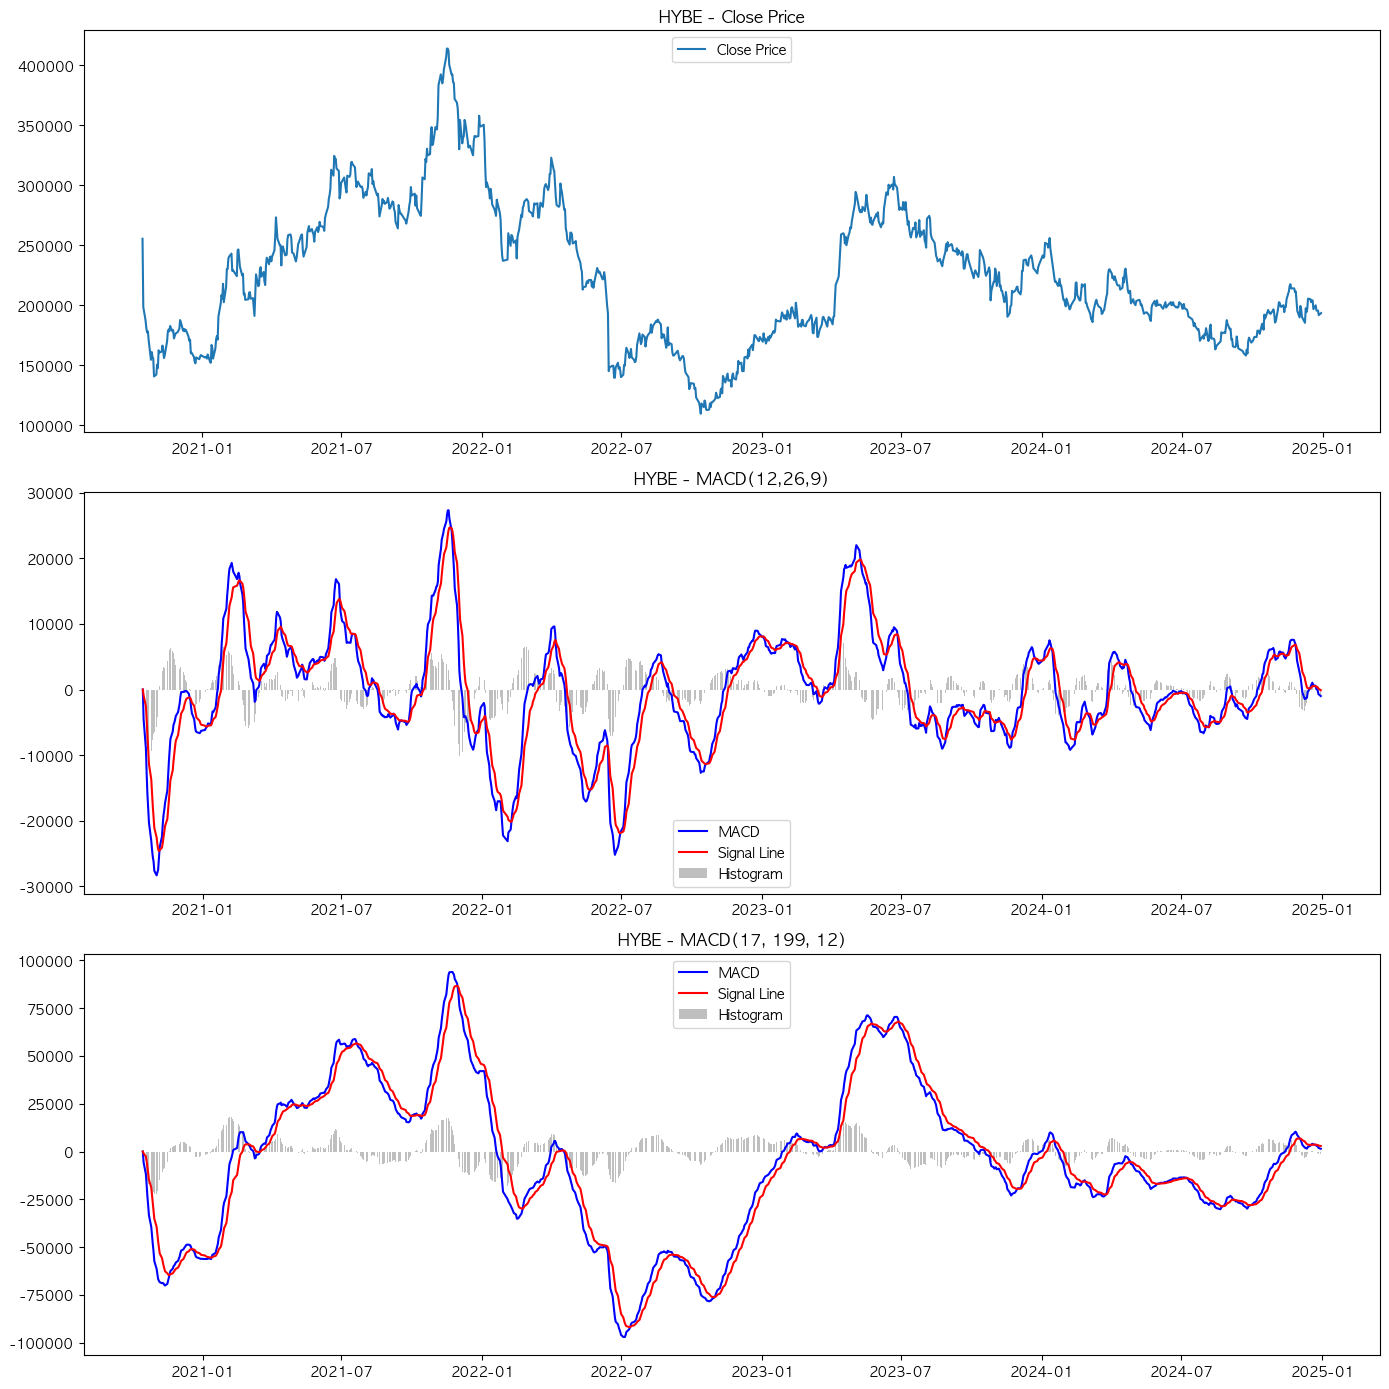

In [45]:
# 하이브 - 최적 alpha 기반의 MACD 그래프 시각화 
plt.figure(figsize=(14,14))

plt.subplot(3,1,1)
draw_close(hybe, 'HYBE', 'upper center')
plt.subplot(3,1,2)
draw_macd(hybe, 'HYBE', 'lower center') # MACD(12,26,9)

plt.subplot(3,1,3)
draw_opt_macd(best_hybe_data_alpha, 'HYBE', best_hybe_day, 'upper center')

plt.tight_layout()
plt.savefig('hybe_optalpha.png')

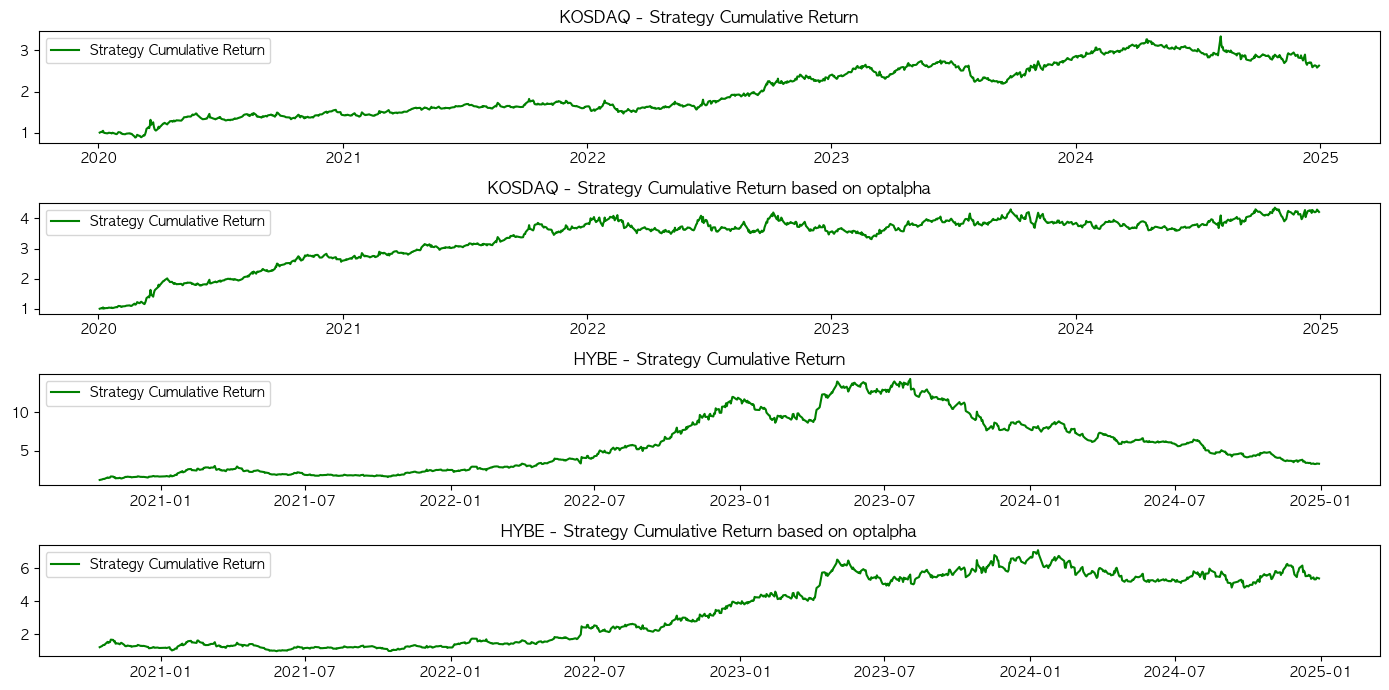

In [46]:
# MACD(12,26,9)와 최적 alpha 기반 누적 수익률 비교 
plt.figure(figsize=(14,7))    

plt.subplot(4,1,1)
plt.plot(kosdaq['Cumulative_Return'], label='Strategy Cumulative Return', color='green')
plt.title('KOSDAQ - Strategy Cumulative Return')
plt.legend(loc='upper left')

plt.subplot(4,1,2)
plt.plot(best_kosdaq_data_alpha['Cumulative_Return'], label='Strategy Cumulative Return', color='green')
plt.title('KOSDAQ - Strategy Cumulative Return based on optalpha')
plt.legend(loc='upper left')

plt.subplot(4,1,3)
plt.plot(hybe['Cumulative_Return'], label='Strategy Cumulative Return', color='green')
plt.title('HYBE - Strategy Cumulative Return')
plt.legend(loc='upper left')

plt.subplot(4,1,4)
plt.plot(best_hybe_data_alpha['Cumulative_Return'], label='Strategy Cumulative Return', color='green')
plt.title('HYBE - Strategy Cumulative Return based on optalpha')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('Cumreturn_optalpha.png')

In [47]:
# 최적의 MACD와 Stochastic 조합 찾기 
def grid_search_sto(data, short_range, long_range, signal_range, k_range, d_range):
    best_return = -np.inf
    best_params = (0, 0, 0, 0, 0)
    best_data = data.copy()

    # 모든 조합 탐색
    for short in short_range:
        for long in long_range:
            for signal in signal_range:
                for k in k_range:
                    for d in d_range:
                        if short >= long or k <= d:
                            continue  # 단기 EMA는 장기 EMA보다 짧고, k는 d보다 길다고 전제 
                        result = cal_macd(data.copy(), short, long, signal)
                        result = cal_sto(result, k, d)
                        result = cal_cumreturn_sto(result)
                        if result.Cumulative_Return_sto.iloc[-1] > best_return: # 최고치 갱
                            best_return = result.Cumulative_Return_sto.iloc[-1]
                            best_params = (short, long, signal, k, d)
                            best_data = result 

    return best_params, best_return, best_data 

In [48]:
short_range = range(8, 16)    # 단기 EMA
long_range = range(20, 31)    # 장기 EMA
signal_range = range(5, 11)   # 시그널 EMA

k_range = range(10, 21)       # %K 기간
d_range = range(3, 8)         # %D 기간

best_kosdaq_params_sto, best_kosdaq_return_sto, best_kosdaq_data_sto = grid_search_sto(kosdaq, short_range, long_range, signal_range, k_range, d_range)
# print(f"코스닥 최적: {best_kosdaq_params_sto}, 누적 수익률: {best_kosdaq_return_sto:.2f}")

best_hybe_params_sto, best_hybe_return_sto, best_hybe_data_sto = grid_search_sto(hybe, short_range, long_range, signal_range, k_range, d_range)
# print(f"하이브 최적: {best_hybe_params_sto}, 누적 수익률: {best_hybe_return_sto:.2f}")

코스닥 최적: (8, 20, 5, 17, 3), 누적 수익률: 3.46
하이브 최적: (15, 30, 10, 18, 7), 누적 수익률: 1.75


In [49]:
# 새로운 파라미터의 Stochastic Oscillator 제목 및 범례 위치 변경 
def draw_opt_sto(data, title, parameter, legend):

    plt.plot(data['%K'], label='%K', color='green')
    plt.plot(data['%D'], label='%D', color='orange')
    plt.axhline(y=80, color='red', linestyle='--', label='Overbought (80)')
    plt.axhline(y=20, color='blue', linestyle='--', label='Oversold (20)')
    plt.title(f'{title} - Stochastic Oscillator (%K={parameter[3]}, %D={parameter[4]})')
    plt.legend(loc=legend, bbox_to_anchor=(0.5,-0.5))

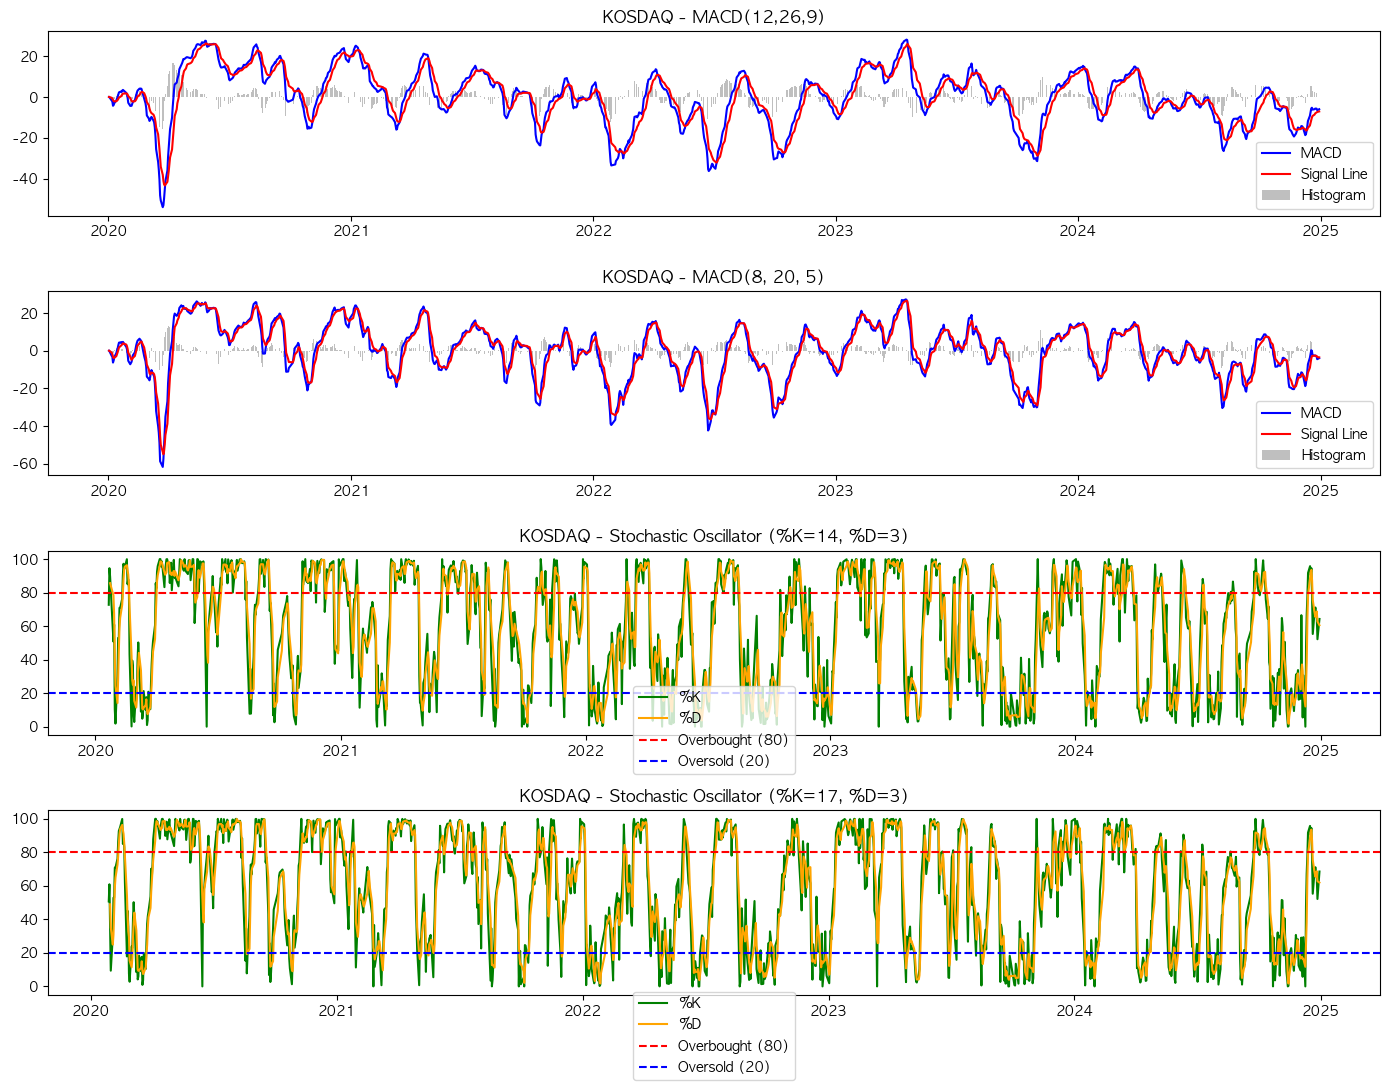

In [50]:
# 코스닥 - 기존 MACD와 최적 MACD & Stochastic 기반 MACD 및 Stochastic Ocillator 그래프  
plt.figure(figsize=(14,11))

plt.subplot(4,1,1)
draw_macd(kosdaq, 'KOSDAQ', 'lower right')

plt.subplot(4,1,2)
draw_opt_macd(best_kosdaq_data_sto, 'KOSDAQ', best_kosdaq_params_sto, 'lower right')

plt.subplot(4,1,3)
draw_sto(kosdaq, 'KOSDAQ', 'lower center')

plt.subplot(4,1,4)
draw_opt_sto(best_kosdaq_data_sto, 'KOSDAQ', best_kosdaq_params_sto, 'lower center')

plt.tight_layout()
plt.savefig('kosdaq_optsto.png')

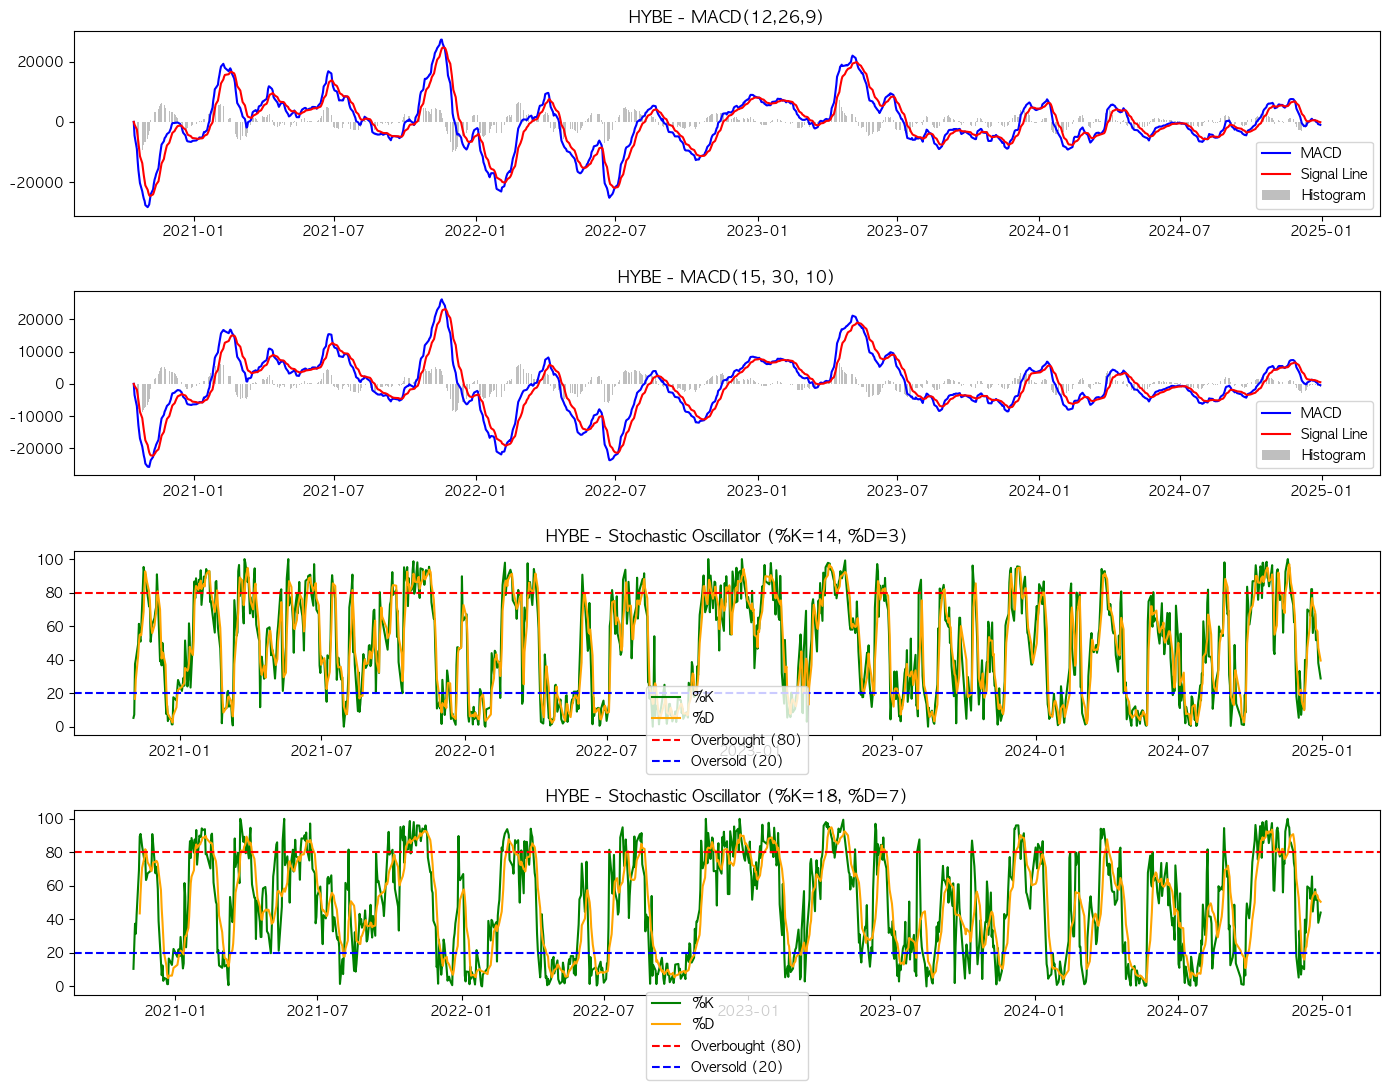

In [51]:
# 하이브 - 기존 MACD와 최적 MACD & Stochastic 기반 MACD 및 Stochastic Ocillator 그래프  
plt.figure(figsize=(14,11))

plt.subplot(4,1,1)
draw_macd(hybe, 'HYBE', 'lower right')

plt.subplot(4,1,2)
draw_opt_macd(best_hybe_data_sto, 'HYBE', best_hybe_params_sto, 'lower right')

plt.subplot(4,1,3)
draw_sto(hybe, 'HYBE', 'lower center')

plt.subplot(4,1,4)
draw_opt_sto(best_hybe_data_sto, 'HYBE', best_hybe_params_sto, 'lower center')

plt.tight_layout()
plt.savefig('hybe_optsto.png')

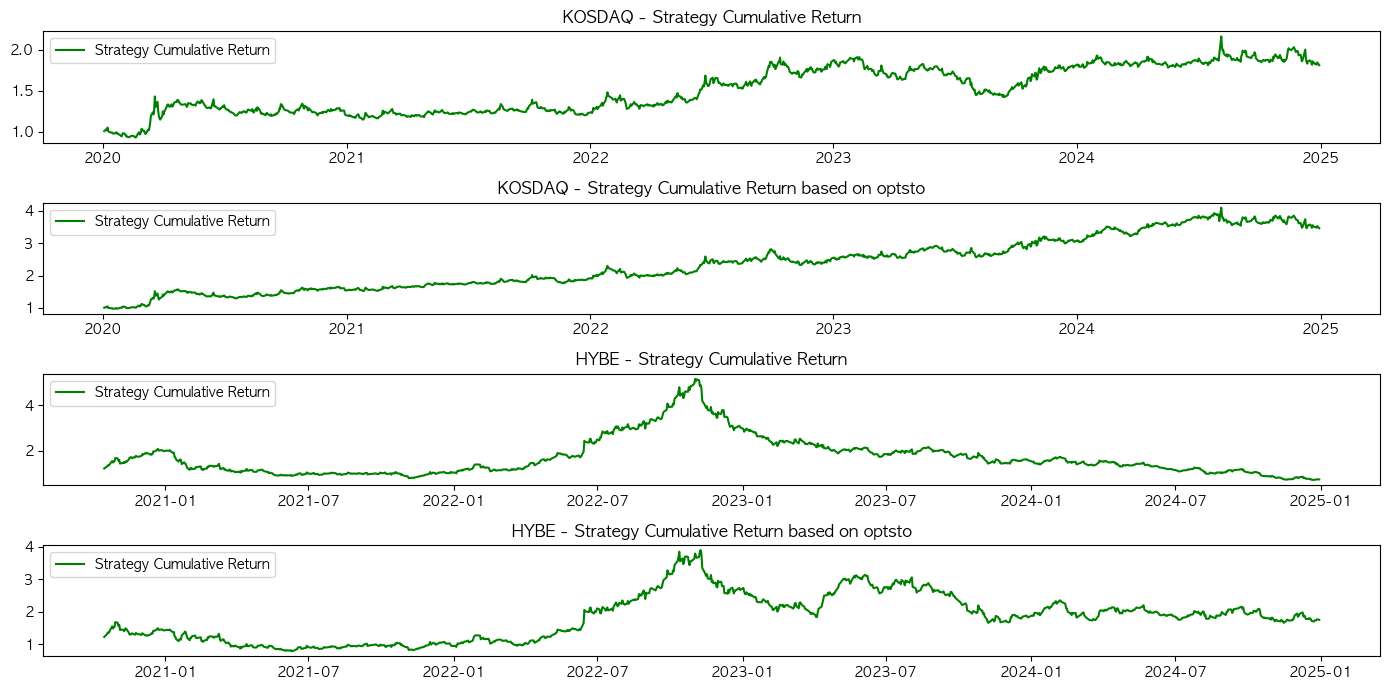

In [52]:
# MACD(12,26,9)와 최적 MACD & Stochastic 누적 수익률 그래프 비교 
plt.figure(figsize=(14,7))    

plt.subplot(4,1,1)
plt.plot(kosdaq['Cumulative_Return_sto'], label='Strategy Cumulative Return', color='green')
plt.title('KOSDAQ - Strategy Cumulative Return')
plt.legend(loc='upper left')

plt.subplot(4,1,2)
plt.plot(best_kosdaq_data_sto['Cumulative_Return_sto'], label='Strategy Cumulative Return', color='green')
plt.title('KOSDAQ - Strategy Cumulative Return based on optsto')
plt.legend(loc='upper left')

plt.subplot(4,1,3)
plt.plot(hybe['Cumulative_Return_sto'], label='Strategy Cumulative Return', color='green')
plt.title('HYBE - Strategy Cumulative Return')
plt.legend(loc='upper left')

plt.subplot(4,1,4)
plt.plot(best_hybe_data_sto['Cumulative_Return_sto'], label='Strategy Cumulative Return', color='green')
plt.title('HYBE - Strategy Cumulative Return based on optsto')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('Cumreturn_optsto.png')